# 三 MNIST⼿写体数据集

## 0 数据生成

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as trans
from torch.utils.data import Subset, DataLoader

devc = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(114514)

In [2]:
train_datasets = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=trans.ToTensor()
)
test_datasets = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=trans.ToTensor()
)


def train_iter(batch_size: int) -> DataLoader:
    return DataLoader(dataset=train_datasets, batch_size=batch_size, shuffle=True)


def test_iter(batch_size: int) -> DataLoader:
    return DataLoader(dataset=test_datasets, batch_size=batch_size, shuffle=False)

## 1 ⼿动实现前馈神经⽹络解决上述回归、⼆分类、多分类任务
分析实验结果并绘制训练集和测试集的loss曲线

In [3]:
class Model:
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        device: torch.device,
    ) -> None:
        self.w1 = torch.normal(
            mean=0,
            std=(2 / input_dim) ** 0.5,
            size=(input_dim, hidden_dim),
            requires_grad=True,
            device=device,
        )
        self.w2 = torch.normal(
            mean=0,
            std=(2 / hidden_dim) ** 0.5,
            size=(hidden_dim, output_dim),
            requires_grad=True,
            device=device,
        )
        self.b1 = torch.zeros(hidden_dim, requires_grad=True, device=device)
        self.b2 = torch.zeros(output_dim, requires_grad=True, device=device)

    def __call__(self, X: torch.Tensor) -> torch.Tensor:
        return self.forward(X)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        if X.dim() > 1:  # 如果X的维度大于1，将其展平为二维张量，以便进行矩阵乘法运算。
            X = X.flatten(start_dim=1)
        z1 = X @ self.w1 + self.b1
        a1 = torch.relu(z1)
        z2 = a1 @ self.w2 + self.b2
        # a2 = torch.softmax(z2, dim=1)
        a2 = z2  # 在loss内再实现softmax，提升数值稳定性
        return a2#.squeeze(-1)   # 必要时压缩最后一维

    def parameters(self) -> list[torch.Tensor]:
        return [self.w1, self.w2, self.b1, self.b2]

In [4]:
class Loss:
    def crossEntropySoftMax(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        log_softmax = y_pred.log_softmax(dim=1)
        return -log_softmax[range(len(y_true)), y_true].mean()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.crossEntropySoftMax(y_pred, y_true)

In [5]:
class Optimizer:
    def __init__(self, model: Model, lr: float = 0.01):
        self.model = model
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.model.parameters():
                if param.grad is not None:
                    param.data -= self.lr * param.grad

    def zero_grad(self):
        with torch.no_grad():
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

In [6]:
def evaluate_loss(
    model: Model, loss: Loss, data_iter: DataLoader, device: torch.device
) -> float:
    with torch.no_grad():
        total_num = 0
        total_loss = 0.0
        for features, labels in data_iter:
            features, labels = features.to(device), labels.to(device)
            predicts = model(features)
            total_num += len(labels)
            total_loss += loss.calc(predicts, labels).item() * len(labels)
        return total_loss / total_num

In [7]:
def train(
    num_epoches: int,
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_iter: DataLoader,
    test_iter: DataLoader,
    device: torch.device,
) -> tuple[list[float], list[float]]:
    train_loss_list, test_loss_list = [], []
    for epoch in range(num_epoches):
        total_num = 0
        train_loss_val = 0
        test_loss_val = 0
        for features, labels in train_iter:
            features, labels = features.to(device), labels.to(device)
            predicts = model(features)
            loss_val = loss.calc(predicts, labels)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            with torch.no_grad():
                total_num += len(labels)
                train_loss_val += loss_val.item() * len(labels)
        train_loss_list.append(train_loss_val / total_num)
        test_loss_val = evaluate_loss(model, loss, test_iter, device)
        test_loss_list.append(test_loss_val)
        print(
            f"Epoch {epoch + 1}, train loss: {train_loss_list[-1]:.4f}, test loss: {test_loss_list[-1]:.4f}"
        )
    return train_loss_list, test_loss_list

In [8]:
num_epoches = 32
input_dim = 1 * 28 * 28
hidden_dim = 256
output_dim = 10
model = Model(input_dim, hidden_dim, output_dim, devc)
loss = Loss()
lr = 0.03
optimizer = Optimizer(model, lr)
batch_size = 10240
train_loader = train_iter(batch_size)
test_loader = test_iter(batch_size)

train_loss_list, test_loss_list = train(
    num_epoches, model, loss, optimizer, train_loader, test_loader, devc
)

Epoch 1, train loss: 2.3295, test loss: 2.2007
Epoch 2, train loss: 2.1275, test loss: 2.0210
Epoch 3, train loss: 1.9611, test loss: 1.8633
Epoch 4, train loss: 1.8127, test loss: 1.7202
Epoch 5, train loss: 1.6775, test loss: 1.5898
Epoch 6, train loss: 1.5545, test loss: 1.4720
Epoch 7, train loss: 1.4436, test loss: 1.3664
Epoch 8, train loss: 1.3444, test loss: 1.2724
Epoch 9, train loss: 1.2563, test loss: 1.1893
Epoch 10, train loss: 1.1784, test loss: 1.1161
Epoch 11, train loss: 1.1098, test loss: 1.0516
Epoch 12, train loss: 1.0492, test loss: 0.9947
Epoch 13, train loss: 0.9956, test loss: 0.9445
Epoch 14, train loss: 0.9482, test loss: 0.9000
Epoch 15, train loss: 0.9061, test loss: 0.8606
Epoch 16, train loss: 0.8685, test loss: 0.8253
Epoch 17, train loss: 0.8350, test loss: 0.7938
Epoch 18, train loss: 0.8049, test loss: 0.7654
Epoch 19, train loss: 0.7777, test loss: 0.7399
Epoch 20, train loss: 0.7531, test loss: 0.7167
Epoch 21, train loss: 0.7307, test loss: 0.6956
E

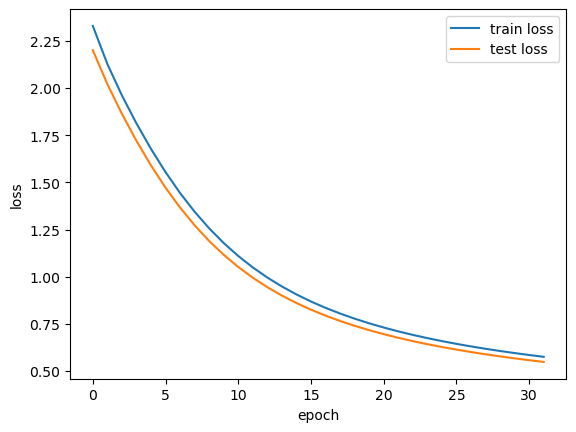

In [9]:
plt.plot(train_loss_list, label="train loss")
plt.plot(test_loss_list, label="test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

## 2 利⽤torch.nn实现前馈神经⽹络解决上述回归、⼆分类、多分类任务
分析实验结果并绘制训练集和测试集的loss曲线

In [10]:
class Model(nn.Module):
    def __init__(
        self, input_dim: int, hidden_dim: int, output_dim: int, device: torch.device
    ) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            # nn.Softmax(dim=1)
        ).to(device)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data, nonlinearity="relu")
                nn.init.zeros_(m.bias.data)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.model(X)#.squeeze(-1)

In [11]:
class Loss:
    def __init__(self) -> None:
        self.criterion = nn.CrossEntropyLoss()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.criterion(y_pred, y_true)

In [12]:
class Optimizer:
    def __init__(self, model: Model, lr: float = 0.01) -> None:
        self.optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    def step(self) -> None:
        self.optimizer.step()

    def zero_grad(self) -> None:
        self.optimizer.zero_grad()

In [13]:
def evaluate_loss(
    model: Model, loss: Loss, data_loader: DataLoader, device: torch.device
) -> float:
    model.eval()
    total_loss = 0.0
    total_num = 0
    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)

            predicts = model(features)
            loss_value = loss.calc(predicts, labels)

            total_num += len(labels)
            total_loss += loss_value.item() * len(labels)
        model.train()
        return total_loss / total_num

In [14]:
def train(
    num_epoches: int,
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_loader: DataLoader,
    test_loader: DataLoader,
    device: torch.device,
):
    train_loss_list, test_loss_list = [], []

    for epoch in range(num_epoches):
        model.train()
        total_num = 0
        train_loss_val = 0
        test_loss_val = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            predicts = model(features)
            loss_value = loss.calc(predicts, labels)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            with torch.no_grad():
                total_num += len(labels)
                train_loss_val += loss_value.item() * len(labels)
        train_loss_list.append(train_loss_val / total_num)
        test_loss_val = evaluate_loss(model, loss, test_loader, device)
        test_loss_list.append(test_loss_val)
        print(
            f"Epoch {epoch + 1}/{num_epoches}, Train Loss: {train_loss_list[-1]:.4f}, Test Loss: {test_loss_list[-1]:.4f}"
        )
    return train_loss_list, test_loss_list

In [15]:
num_epoches = 32
input_dim = 1 * 28 * 28
hidden_dim = 256
output_dim = 10
model = Model(input_dim, hidden_dim, output_dim, devc)
loss = Loss()
lr = 0.03
optimizer = Optimizer(model, lr)
batch_size = 10240
train_loader = train_iter(batch_size)
test_loader = test_iter(batch_size)

train_loss_list, test_loss_list = train(
    num_epoches, model, loss, optimizer, train_loader, test_loader, devc
)

Epoch 1/32, Train Loss: 2.3133, Test Loss: 2.1651
Epoch 2/32, Train Loss: 2.0852, Test Loss: 1.9737
Epoch 3/32, Train Loss: 1.9106, Test Loss: 1.8115
Epoch 4/32, Train Loss: 1.7593, Test Loss: 1.6673
Epoch 5/32, Train Loss: 1.6243, Test Loss: 1.5381
Epoch 6/32, Train Loss: 1.5034, Test Loss: 1.4228
Epoch 7/32, Train Loss: 1.3958, Test Loss: 1.3206
Epoch 8/32, Train Loss: 1.3004, Test Loss: 1.2305
Epoch 9/32, Train Loss: 1.2163, Test Loss: 1.1514
Epoch 10/32, Train Loss: 1.1425, Test Loss: 1.0822
Epoch 11/32, Train Loss: 1.0778, Test Loss: 1.0215
Epoch 12/32, Train Loss: 1.0208, Test Loss: 0.9681
Epoch 13/32, Train Loss: 0.9706, Test Loss: 0.9211
Epoch 14/32, Train Loss: 0.9262, Test Loss: 0.8794
Epoch 15/32, Train Loss: 0.8867, Test Loss: 0.8424
Epoch 16/32, Train Loss: 0.8516, Test Loss: 0.8094
Epoch 17/32, Train Loss: 0.8201, Test Loss: 0.7798
Epoch 18/32, Train Loss: 0.7918, Test Loss: 0.7531
Epoch 19/32, Train Loss: 0.7662, Test Loss: 0.7291
Epoch 20/32, Train Loss: 0.7430, Test Lo

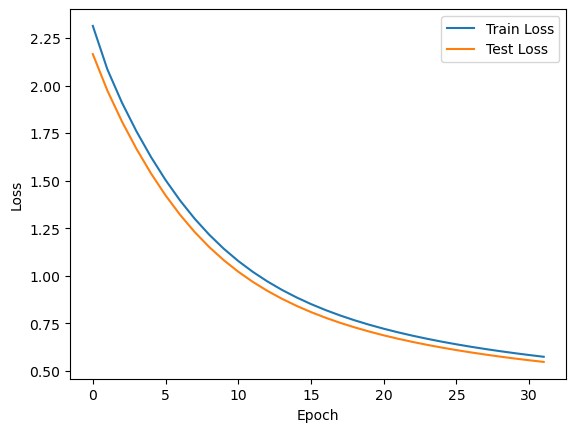

In [16]:
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 3 在多分类实验的基础上使⽤⾄少三种不同的激活函数
对比使用不同激活函数的实验结果

In [17]:
# NOTE 题目3：重构Model类，增加传入的参数"activation_fn"，用于指定激活函数，默认为ReLU。在forward方法中使用传入的激活函数。"
class Model(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        device: torch.device,
        activation_fn: nn.Module = nn.ReLU(),
    ) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            activation_fn,
            nn.Linear(hidden_dim, output_dim),
            # nn.Softmax(dim=1)
        ).to(device)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data, nonlinearity="relu")
                nn.init.zeros_(m.bias.data)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.model(X)  # .squeeze(-1)

In [18]:
class Loss:
    def __init__(self) -> None:
        self.criterion = nn.CrossEntropyLoss()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.criterion(y_pred, y_true)

In [19]:
class Optimizer:
    def __init__(self, model: Model, lr: float = 0.01) -> None:
        self.optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    def step(self) -> None:
        self.optimizer.step()

    def zero_grad(self) -> None:
        self.optimizer.zero_grad()

In [20]:
def evaluate_loss(
    model: Model, loss: Loss, data_loader: DataLoader, device: torch.device
) -> float:
    model.eval()
    total_loss = 0.0
    total_num = 0
    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)

            predicts = model(features)
            loss_value = loss.calc(predicts, labels)

            total_num += len(labels)
            total_loss += loss_value.item() * len(labels)
        model.train()
        return total_loss / total_num

In [21]:
def train(
    num_epoches: int,
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_loader: DataLoader,
    test_loader: DataLoader,
    device: torch.device,
):
    train_loss_list, test_loss_list = [], []

    for epoch in range(num_epoches):
        model.train()
        total_num = 0
        train_loss_val = 0
        test_loss_val = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            predicts = model(features)
            loss_value = loss.calc(predicts, labels)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            with torch.no_grad():
                total_num += len(labels)
                train_loss_val += loss_value.item() * len(labels)
        train_loss_list.append(train_loss_val / total_num)
        test_loss_val = evaluate_loss(model, loss, test_loader, device)
        test_loss_list.append(test_loss_val)
        print(
            f"Epoch {epoch + 1}/{num_epoches}, Train Loss: {train_loss_list[-1]:.4f}, Test Loss: {test_loss_list[-1]:.4f}"
        )
    return train_loss_list, test_loss_list

In [22]:
# 注： 在 "2" 的基础上实现，重构了Model类
num_epoches = 32
input_dim = 1 * 28 * 28
hidden_dim = 256
output_dim = 10
### ==================================================================
# model_relu = Model(input_dim, hidden_dim, output_dim, devc, nn.ReLU())    # 先前跑的就是ReLU激活函数的，故此处不再重复跑了
model_sig = Model(input_dim, hidden_dim, output_dim, devc, nn.Sigmoid())
model_tanh = Model(input_dim, hidden_dim, output_dim, devc, nn.Tanh())
# ==================================================================
loss = Loss()
lr = 0.03
### ==================================================================
# optimizer_relu = Optimizer(model_relu, lr)    # 同上
optimizer_sig = Optimizer(model_sig, lr)
optimizer_tanh = Optimizer(model_tanh, lr)
# ==================================================================
batch_size = 10240
train_loader = train_iter(batch_size)
test_loader = test_iter(batch_size)

train_loss_list_relu, test_loss_list_relu = train_loss_list, test_loss_list
train_loss_list_sig, test_loss_list_sig = train(
    num_epoches, model_sig, loss, optimizer_sig, train_loader, test_loader, devc
)
train_loss_list_tanh, test_loss_list_tanh = train(
    num_epoches, model_tanh, loss, optimizer_tanh, train_loader, test_loader, devc
)

Epoch 1/32, Train Loss: 2.4759, Test Loss: 2.3044
Epoch 2/32, Train Loss: 2.2778, Test Loss: 2.2522
Epoch 3/32, Train Loss: 2.2396, Test Loss: 2.2229
Epoch 4/32, Train Loss: 2.2119, Test Loss: 2.1957
Epoch 5/32, Train Loss: 2.1854, Test Loss: 2.1690
Epoch 6/32, Train Loss: 2.1593, Test Loss: 2.1426
Epoch 7/32, Train Loss: 2.1336, Test Loss: 2.1166
Epoch 8/32, Train Loss: 2.1082, Test Loss: 2.0909
Epoch 9/32, Train Loss: 2.0831, Test Loss: 2.0655
Epoch 10/32, Train Loss: 2.0583, Test Loss: 2.0404
Epoch 11/32, Train Loss: 2.0338, Test Loss: 2.0156
Epoch 12/32, Train Loss: 2.0095, Test Loss: 1.9910
Epoch 13/32, Train Loss: 1.9855, Test Loss: 1.9667
Epoch 14/32, Train Loss: 1.9617, Test Loss: 1.9427
Epoch 15/32, Train Loss: 1.9382, Test Loss: 1.9189
Epoch 16/32, Train Loss: 1.9150, Test Loss: 1.8953
Epoch 17/32, Train Loss: 1.8919, Test Loss: 1.8721
Epoch 18/32, Train Loss: 1.8691, Test Loss: 1.8490
Epoch 19/32, Train Loss: 1.8465, Test Loss: 1.8261
Epoch 20/32, Train Loss: 1.8242, Test Lo

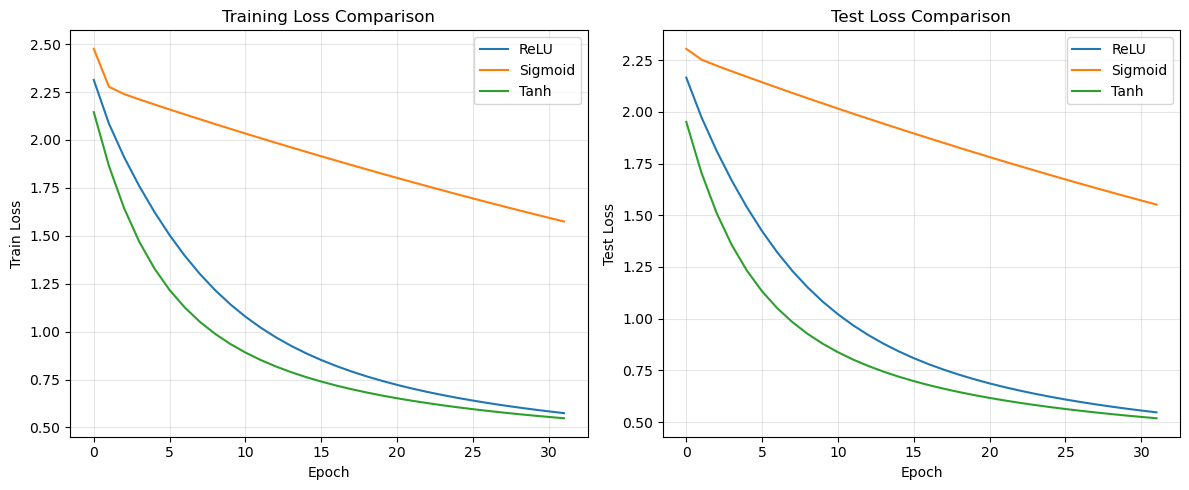

In [23]:
# 创建1x2的子图
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 第一张图：训练损失
axes[0].plot(range(num_epoches), train_loss_list_relu, label="ReLU")
axes[0].plot(range(num_epoches), train_loss_list_sig, label="Sigmoid")
axes[0].plot(range(num_epoches), train_loss_list_tanh, label="Tanh")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Train Loss")
axes[0].set_title("Training Loss Comparison")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 第二张图：测试损失
axes[1].plot(range(num_epoches), test_loss_list_relu, label="ReLU")
axes[1].plot(range(num_epoches), test_loss_list_sig, label="Sigmoid")
axes[1].plot(range(num_epoches), test_loss_list_tanh, label="Tanh")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Test Loss")
axes[1].set_title("Test Loss Comparison")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 调整子图间距
plt.tight_layout()
plt.show()

## 4 对多分类任务中的模型评估隐藏层层数和隐藏单元个数对实验结果的影响
使用不同的隐藏层层数和隐藏单元个数，进行对比实验并分析实验结果  \
对比至少三组

In [24]:
# NOTE 题目4：再次重构Model类，增加传入的参数"hidden_layers_num"，使得模型可以有多个隐藏层。
class Model(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        device: torch.device,
        activation_fn: nn.Module = nn.ReLU(),
        hidden_layers_num: int = 1,
    ) -> None:
        super().__init__()
        hidden_layers = []
        for _ in range(hidden_layers_num - 1):  # 注意是 hidden_layers_num-1
            hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            hidden_layers.append(activation_fn)
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),  # 第一层
            activation_fn,  # 激活函数
            *hidden_layers,  # 解包所有隐藏层
            nn.Linear(hidden_dim, output_dim),  # 输出层
        ).to(device)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data, nonlinearity="relu")
                nn.init.zeros_(m.bias.data)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.model(X)  # .squeeze(-1)

In [25]:
class Loss:
    def __init__(self) -> None:
        self.criterion = nn.CrossEntropyLoss()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.criterion(y_pred, y_true)

In [26]:
class Optimizer:
    def __init__(self, model: Model, lr: float = 0.01) -> None:
        self.optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    def step(self) -> None:
        self.optimizer.step()

    def zero_grad(self) -> None:
        self.optimizer.zero_grad()

In [27]:
def evaluate_loss(
    model: Model, loss: Loss, data_loader: DataLoader, device: torch.device
) -> float:
    model.eval()
    total_loss = 0.0
    total_num = 0
    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)

            predicts = model(features)
            loss_value = loss.calc(predicts, labels)

            total_num += len(labels)
            total_loss += loss_value.item() * len(labels)
        model.train()
        return total_loss / total_num

In [28]:
def train(
    num_epoches: int,
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_loader: DataLoader,
    test_loader: DataLoader,
    device: torch.device,
):
    train_loss_list, test_loss_list = [], []

    for epoch in range(num_epoches):
        model.train()
        total_num = 0
        train_loss_val = 0
        test_loss_val = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            predicts = model(features)
            loss_value = loss.calc(predicts, labels)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            with torch.no_grad():
                total_num += len(labels)
                train_loss_val += loss_value.item() * len(labels)
        train_loss_list.append(train_loss_val / total_num)
        test_loss_val = evaluate_loss(model, loss, test_loader, device)
        test_loss_list.append(test_loss_val)
        print(
            f"Epoch {epoch + 1}/{num_epoches}, Train Loss: {train_loss_list[-1]:.4f}, Test Loss: {test_loss_list[-1]:.4f}"
        )
    return train_loss_list, test_loss_list

In [29]:
# 注： 在 "3" 的基础上实现，重构了Model类
num_epoches = 32
input_dim = 1 * 28 * 28
# hidden_dim = 256
output_dim = 10
### ==================================================================
# model_layers1HiddenDim256 = Model(input_dim, 256, output_dim, devc, nn.Sigmoid(), 1)    # 先前跑的就是这个
model_layers1HiddenDim64 = Model(input_dim, 64, output_dim, devc, nn.Sigmoid(), 1)
model_layers2HiddenDim256 = Model(input_dim, 256, output_dim, devc, nn.Tanh(), 2)
# ==================================================================
loss = Loss()
lr = 0.03
### ==================================================================
# optimizer_layers1HiddenDim256 = Optimizer(model_layers1HiddenDim256, lr)    # 同上
optimizer_layers1HiddenDim64 = Optimizer(model_layers1HiddenDim64, lr)
optimizer_layers2HiddenDim256 = Optimizer(model_layers2HiddenDim256, lr)
# ==================================================================
batch_size = 10240
train_loader = train_iter(batch_size)
test_loader = test_iter(batch_size)

train_loss_list_layers1HiddenDim256, test_loss_list_layers1HiddenDim256 = (
    train_loss_list,
    test_loss_list,
)
train_loss_list_layers1HiddenDim64, test_loss_list_layers1HiddenDim64 = train(
    num_epoches,
    model_layers1HiddenDim64,
    loss,
    optimizer_layers1HiddenDim64,
    train_loader,
    test_loader,
    devc,
)
train_loss_list_layers2HiddenDim256, test_loss_list_layers2HiddenDim256 = train(
    num_epoches,
    model_layers2HiddenDim256,
    loss,
    optimizer_layers2HiddenDim256,
    train_loader,
    test_loader,
    devc,
)

Epoch 1/32, Train Loss: 2.4240, Test Loss: 2.3668
Epoch 2/32, Train Loss: 2.3336, Test Loss: 2.2995
Epoch 3/32, Train Loss: 2.2786, Test Loss: 2.2552
Epoch 4/32, Train Loss: 2.2409, Test Loss: 2.2225
Epoch 5/32, Train Loss: 2.2119, Test Loss: 2.1957
Epoch 6/32, Train Loss: 2.1872, Test Loss: 2.1719
Epoch 7/32, Train Loss: 2.1648, Test Loss: 2.1497
Epoch 8/32, Train Loss: 2.1437, Test Loss: 2.1285
Epoch 9/32, Train Loss: 2.1233, Test Loss: 2.1079
Epoch 10/32, Train Loss: 2.1033, Test Loss: 2.0877
Epoch 11/32, Train Loss: 2.0837, Test Loss: 2.0678
Epoch 12/32, Train Loss: 2.0643, Test Loss: 2.0481
Epoch 13/32, Train Loss: 2.0451, Test Loss: 2.0287
Epoch 14/32, Train Loss: 2.0262, Test Loss: 2.0095
Epoch 15/32, Train Loss: 2.0074, Test Loss: 1.9905
Epoch 16/32, Train Loss: 1.9889, Test Loss: 1.9716
Epoch 17/32, Train Loss: 1.9705, Test Loss: 1.9530
Epoch 18/32, Train Loss: 1.9522, Test Loss: 1.9345
Epoch 19/32, Train Loss: 1.9342, Test Loss: 1.9162
Epoch 20/32, Train Loss: 1.9163, Test Lo

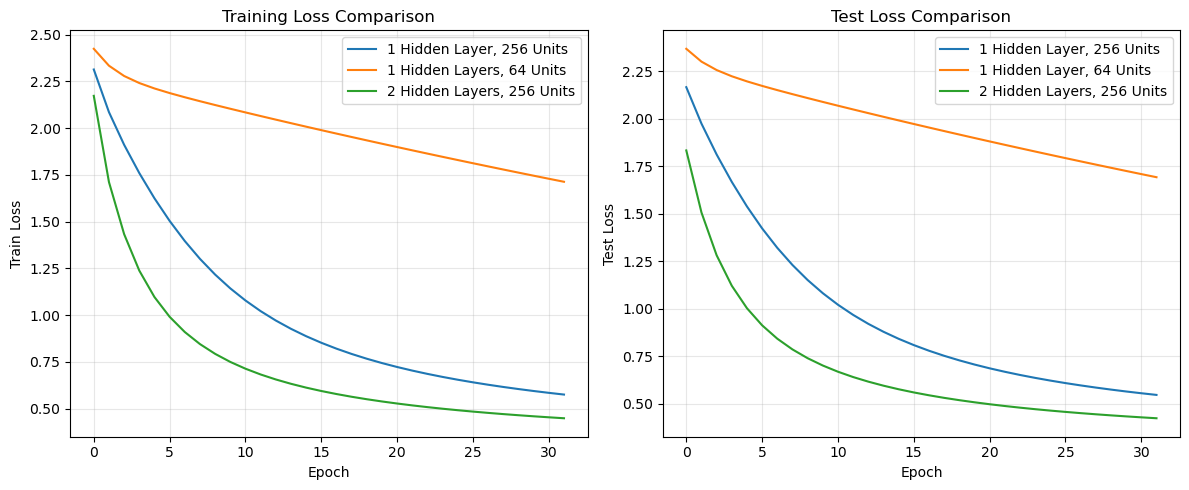

In [30]:
# 创建1x2的子图
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 第一张图：训练损失
axes[0].plot(
    range(num_epoches),
    train_loss_list_layers1HiddenDim256,
    label="1 Hidden Layer, 256 Units",
)
axes[0].plot(
    range(num_epoches),
    train_loss_list_layers1HiddenDim64,
    label="1 Hidden Layers, 64 Units",
)
axes[0].plot(
    range(num_epoches),
    train_loss_list_layers2HiddenDim256,
    label="2 Hidden Layers, 256 Units",
)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Train Loss")
axes[0].set_title("Training Loss Comparison")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 第二张图：测试损失
axes[1].plot(
    range(num_epoches),
    test_loss_list_layers1HiddenDim256,
    label="1 Hidden Layer, 256 Units",
)
axes[1].plot(
    range(num_epoches),
    test_loss_list_layers1HiddenDim64,
    label="1 Hidden Layer, 64 Units",
)
axes[1].plot(
    range(num_epoches),
    test_loss_list_layers2HiddenDim256,
    label="2 Hidden Layers, 256 Units",
)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Test Loss")
axes[1].set_title("Test Loss Comparison")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 调整子图间距
plt.tight_layout()
plt.show()

## 5  在多分类任务实验中分别⼿动实现和⽤torch.nn实现dropout
探究不同丢弃率对实验结果的影响（可用loss曲线进行展示）

### 5.1 手动实现dropout


In [31]:
# 题目5：手动实现dropout，重构Model类，
#       增加传入dropout_rate参数，实现forward函数中的dropout逻辑
#       增加.eval()、.train()方法，改变模型的训练状态
class Model:
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        device: torch.device,
        drop_rate: float,
    ) -> None:
        self.device = device
        self.train_mode = True
        self.drop_rate = drop_rate
        self.w1 = torch.normal(
            mean=0,
            std=(2 / input_dim) ** 0.5,
            size=(input_dim, hidden_dim),
            requires_grad=True,
            device=self.device,
        )
        self.w2 = torch.normal(
            mean=0,
            std=(2 / hidden_dim) ** 0.5,
            size=(hidden_dim, output_dim),
            requires_grad=True,
            device=self.device,
        )
        self.b1 = torch.zeros(hidden_dim, requires_grad=True, device=self.device)
        self.b2 = torch.zeros(output_dim, requires_grad=True, device=self.device)

    def __call__(self, X: torch.Tensor) -> torch.Tensor:
        return self.forward(X)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        if X.dim() > 1:  # 如果X的维度大于1，将其展平为二维张量，以便进行矩阵乘法运算。
            X = X.flatten(start_dim=1)
        z1 = X @ self.w1 + self.b1
        a1 = torch.relu(z1)
        if self.train_mode == True:
            a1 = self.drop_out(a1)
        z2 = a1 @ self.w2 + self.b2
        # a2 = torch.softmax(z2, dim=1)
        a2 = z2  # 在loss内再实现softmax，提升数值稳定性
        if self.train_mode == True:
            a2 = self.drop_out(a2)
        return a2  # .squeeze(-1)   # 必要时压缩最后一维

    def parameters(self) -> list[torch.Tensor]:
        return [self.w1, self.w2, self.b1, self.b2]

    def train(self):
        self.train_mode = True

    def eval(self):
        self.train_mode = False

    def drop_out(self, X: torch.Tensor):
        X = X.float()
        keep_rate = 1 - self.drop_rate
        assert 0 <= keep_rate <= 1
        mask = torch.rand(X.shape, device=self.device) < keep_rate
        return X * mask / keep_rate

In [32]:
class Loss:
    def crossEntropySoftMax(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        log_softmax = y_pred.log_softmax(dim=1)
        return -log_softmax[range(len(y_true)), y_true].mean()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.crossEntropySoftMax(y_pred, y_true)

In [33]:
class Optimizer:
    def __init__(self, model: Model, lr: float = 0.01):
        self.model = model
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.model.parameters():
                if param.grad is not None:
                    param.data -= self.lr * param.grad

    def zero_grad(self):
        with torch.no_grad():
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

In [34]:
def evaluate_loss(
    model: Model, loss: Loss, data_iter: DataLoader, device: torch.device
) -> float:
    model.eval()
    with torch.no_grad():
        total_num = 0
        total_loss = 0.0
        for features, labels in data_iter:
            features, labels = features.to(device), labels.to(device)
            predicts = model(features)
            total_num += len(labels)
            total_loss += loss.calc(predicts, labels).item() * len(labels)
        model.train()
        return total_loss / total_num

In [35]:
def train(
    num_epoches: int,
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_iter: DataLoader,
    test_iter: DataLoader,
    device: torch.device,
) -> tuple[list[float], list[float]]:
    train_loss_list, test_loss_list = [], []
    for epoch in range(num_epoches):
        model.train()
        total_num = 0
        train_loss_val = 0
        test_loss_val = 0
        for features, labels in train_iter:
            features, labels = features.to(device), labels.to(device)
            predicts = model(features)
            loss_val = loss.calc(predicts, labels)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            with torch.no_grad():
                total_num += len(labels)
                train_loss_val += loss_val.item() * len(labels)
        train_loss_list.append(train_loss_val / total_num)
        test_loss_val = evaluate_loss(model, loss, test_iter, device)
        test_loss_list.append(test_loss_val)
        print(
            f"Epoch {epoch + 1}, train loss: {train_loss_list[-1]:.4f}, test loss: {test_loss_list[-1]:.4f}"
        )
    return train_loss_list, test_loss_list

In [36]:
num_epoches = 32
input_dim = 1 * 28 * 28
hidden_dim = 256
output_dim = 10
### ==================================================================
# 分别使用0.3和0.7的dropout概率训练模型
model_drop0_3 = Model(input_dim, hidden_dim, output_dim, devc, 0.3)
model_drop0_7 = Model(input_dim, hidden_dim, output_dim, devc, 0.7)
# ==================================================================
loss = Loss()
lr = 0.03
### ==================================================================
optimizer_drop0_3 = Optimizer(model_drop0_3, lr)
optimizer_drop0_7 = Optimizer(model_drop0_7, lr)
# ==================================================================
batch_size = 10240
train_loader = train_iter(batch_size)
test_loader = test_iter(batch_size)

train_loss_list_drop0_3, test_loss_list_drop0_3 = train(
    num_epoches, model_drop0_3, loss, optimizer_drop0_3, train_loader, test_loader, devc
)
train_loss_list_drop0_7, test_loss_list_drop0_7 = train(
    num_epoches, model_drop0_7, loss, optimizer_drop0_7, train_loader, test_loader, devc
)

Epoch 1, train loss: 2.3977, test loss: 2.2140
Epoch 2, train loss: 2.2184, test loss: 2.0585
Epoch 3, train loss: 2.0806, test loss: 1.9246
Epoch 4, train loss: 1.9664, test loss: 1.8047
Epoch 5, train loss: 1.8630, test loss: 1.6965
Epoch 6, train loss: 1.7756, test loss: 1.5987
Epoch 7, train loss: 1.6996, test loss: 1.5103
Epoch 8, train loss: 1.6298, test loss: 1.4305
Epoch 9, train loss: 1.5666, test loss: 1.3585
Epoch 10, train loss: 1.5165, test loss: 1.2936
Epoch 11, train loss: 1.4687, test loss: 1.2354
Epoch 12, train loss: 1.4343, test loss: 1.1833
Epoch 13, train loss: 1.3969, test loss: 1.1358
Epoch 14, train loss: 1.3633, test loss: 1.0930
Epoch 15, train loss: 1.3326, test loss: 1.0540
Epoch 16, train loss: 1.3067, test loss: 1.0183
Epoch 17, train loss: 1.2848, test loss: 0.9859
Epoch 18, train loss: 1.2566, test loss: 0.9556
Epoch 19, train loss: 1.2411, test loss: 0.9281
Epoch 20, train loss: 1.2230, test loss: 0.9028
Epoch 21, train loss: 1.2069, test loss: 0.8792
E

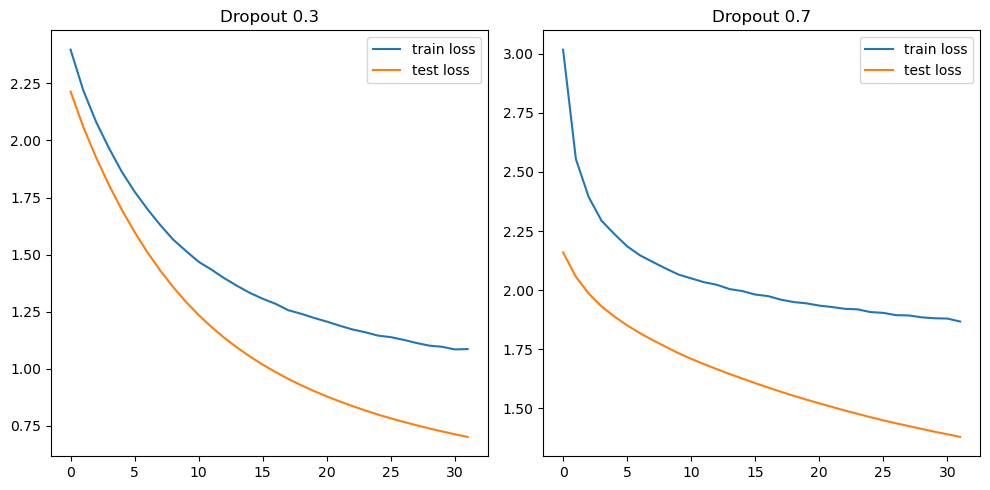

In [37]:
figure, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(train_loss_list_drop0_3, label="train loss")
axes[0].plot(test_loss_list_drop0_3, label="test loss")
axes[0].set_title("Dropout 0.3")
axes[0].legend()

axes[1].plot(train_loss_list_drop0_7, label="train loss")
axes[1].plot(test_loss_list_drop0_7, label="test loss")
axes[1].set_title("Dropout 0.7")
axes[1].legend()

plt.tight_layout()
plt.show()

### 5.2 nn实现dropropout

In [38]:
# 题目5：nn实现dropout，重构Model类，
#       增加传入dropout_rate参数，实现forward函数中的dropout逻辑
class Model(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        device: torch.device,
        dropout_rate: float,
    ) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),  # Add dropout layer here
            nn.Linear(hidden_dim, output_dim),
            # nn.Softmax(dim=1)
            nn.Dropout(p=dropout_rate),  # Add dropout layer here
        ).to(device)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data, nonlinearity="relu")
                nn.init.zeros_(m.bias.data)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.model(X)  # .squeeze(-1)

In [39]:
class Loss:
    def __init__(self) -> None:
        self.criterion = nn.CrossEntropyLoss()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.criterion(y_pred, y_true)

In [40]:
class Optimizer:
    def __init__(self, model: Model, lr: float = 0.01) -> None:
        self.optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    def step(self) -> None:
        self.optimizer.step()

    def zero_grad(self) -> None:
        self.optimizer.zero_grad()

In [41]:
def evaluate_loss(
    model: Model, loss: Loss, data_loader: DataLoader, device: torch.device
) -> float:
    model.eval()
    total_loss = 0.0
    total_num = 0
    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)

            predicts = model(features)
            loss_value = loss.calc(predicts, labels)

            total_num += len(labels)
            total_loss += loss_value.item() * len(labels)
        model.train()
        return total_loss / total_num

In [42]:
def train(
    num_epoches: int,
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_loader: DataLoader,
    test_loader: DataLoader,
    device: torch.device,
):
    train_loss_list, test_loss_list = [], []

    for epoch in range(num_epoches):
        model.train()
        total_num = 0
        train_loss_val = 0
        test_loss_val = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            predicts = model(features)
            loss_value = loss.calc(predicts, labels)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            with torch.no_grad():
                total_num += len(labels)
                train_loss_val += loss_value.item() * len(labels)
        train_loss_list.append(train_loss_val / total_num)
        test_loss_val = evaluate_loss(model, loss, test_loader, device)
        test_loss_list.append(test_loss_val)
        print(
            f"Epoch {epoch + 1}/{num_epoches}, Train Loss: {train_loss_list[-1]:.4f}, Test Loss: {test_loss_list[-1]:.4f}"
        )
    return train_loss_list, test_loss_list

In [43]:
num_epoches = 32
input_dim = 1 * 28 * 28
hidden_dim = 256
output_dim = 10
### ==================================================================
# 分别使用0.3和0.7的dropout概率训练模型
model_drop0_3 = Model(input_dim, hidden_dim, output_dim, devc, 0.3)
model_drop0_7 = Model(input_dim, hidden_dim, output_dim, devc, 0.7)
# ==================================================================
loss = Loss()
lr = 0.03
### ==================================================================
optimizer_drop0_3 = Optimizer(model_drop0_3, lr)
optimizer_drop0_7 = Optimizer(model_drop0_7, lr)
# ==================================================================
batch_size = 10240
train_loader = train_iter(batch_size)
test_loader = test_iter(batch_size)

train_loss_list_drop0_3, test_loss_list_drop0_3 = train(
    num_epoches, model_drop0_3, loss, optimizer_drop0_3, train_loader, test_loader, devc
)
train_loss_list_drop0_7, test_loss_list_drop0_7 = train(
    num_epoches, model_drop0_7, loss, optimizer_drop0_7, train_loader, test_loader, devc
)

Epoch 1/32, Train Loss: 2.4416, Test Loss: 2.1934
Epoch 2/32, Train Loss: 2.1956, Test Loss: 2.0204
Epoch 3/32, Train Loss: 2.0499, Test Loss: 1.8832
Epoch 4/32, Train Loss: 1.9340, Test Loss: 1.7647
Epoch 5/32, Train Loss: 1.8357, Test Loss: 1.6603
Epoch 6/32, Train Loss: 1.7525, Test Loss: 1.5674
Epoch 7/32, Train Loss: 1.6754, Test Loss: 1.4838
Epoch 8/32, Train Loss: 1.6167, Test Loss: 1.4099
Epoch 9/32, Train Loss: 1.5587, Test Loss: 1.3431
Epoch 10/32, Train Loss: 1.5143, Test Loss: 1.2832
Epoch 11/32, Train Loss: 1.4711, Test Loss: 1.2293
Epoch 12/32, Train Loss: 1.4291, Test Loss: 1.1803
Epoch 13/32, Train Loss: 1.4075, Test Loss: 1.1365
Epoch 14/32, Train Loss: 1.3629, Test Loss: 1.0956
Epoch 15/32, Train Loss: 1.3393, Test Loss: 1.0590
Epoch 16/32, Train Loss: 1.3147, Test Loss: 1.0252
Epoch 17/32, Train Loss: 1.2895, Test Loss: 0.9942
Epoch 18/32, Train Loss: 1.2693, Test Loss: 0.9655
Epoch 19/32, Train Loss: 1.2513, Test Loss: 0.9393
Epoch 20/32, Train Loss: 1.2312, Test Lo

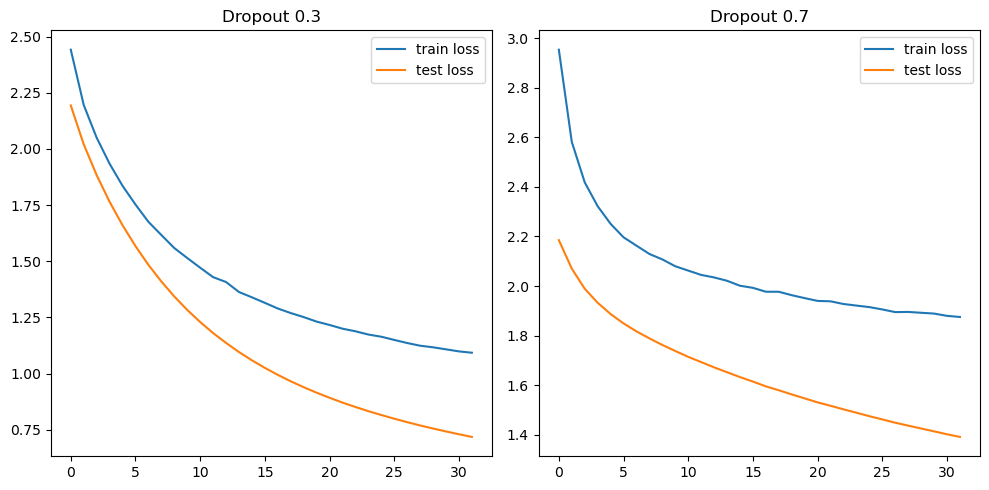

In [44]:
figure, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(train_loss_list_drop0_3, label="train loss")
axes[0].plot(test_loss_list_drop0_3, label="test loss")
axes[0].set_title("Dropout 0.3")
axes[0].legend()

axes[1].plot(train_loss_list_drop0_7, label="train loss")
axes[1].plot(test_loss_list_drop0_7, label="test loss")
axes[1].set_title("Dropout 0.7")
axes[1].legend()

plt.tight_layout()
plt.show()

## 6 在多分类任务实验中分别手动实现和用torch.nn实现𝑳𝟐正则化
探究惩罚项的权重对实验结果的影响（可用loss曲线进行展示）

### 6.1 手动实现L2正则化

In [45]:
class Model:
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        device: torch.device,
    ) -> None:
        self.w1 = torch.normal(
            mean=0,
            std=(2 / input_dim) ** 0.5,
            size=(input_dim, hidden_dim),
            requires_grad=True,
            device=device,
        )
        self.w2 = torch.normal(
            mean=0,
            std=(2 / hidden_dim) ** 0.5,
            size=(hidden_dim, output_dim),
            requires_grad=True,
            device=device,
        )
        self.b1 = torch.zeros(hidden_dim, requires_grad=True, device=device)
        self.b2 = torch.zeros(output_dim, requires_grad=True, device=device)

    def __call__(self, X: torch.Tensor) -> torch.Tensor:
        return self.forward(X)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        if X.dim() > 1:  # 如果X的维度大于1，将其展平为二维张量，以便进行矩阵乘法运算。
            X = X.flatten(start_dim=1)
        z1 = X @ self.w1 + self.b1
        a1 = torch.relu(z1)
        z2 = a1 @ self.w2 + self.b2
        # a2 = torch.softmax(z2, dim=1)
        a2 = z2  # 在loss内再实现softmax，提升数值稳定性
        return a2  # .squeeze(-1)   # 必要时压缩最后一维

    def parameters(self) -> list[torch.Tensor]:
        return [self.w1, self.w2, self.b1, self.b2]

    def params_weight(self) -> list[torch.Tensor]:
        return [self.w1, self.w2]

In [46]:
class Loss:
    def crossEntropySoftMax(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        log_softmax = y_pred.log_softmax(dim=1)
        return -log_softmax[range(len(y_true)), y_true].mean()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.crossEntropySoftMax(y_pred, y_true)

In [47]:
class Optimizer:
    def __init__(self, model: Model, lr: float = 0.01):
        self.model = model
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.model.parameters():
                if param.grad is not None:
                    param.data -= self.lr * param.grad

    def zero_grad(self):
        with torch.no_grad():
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

In [48]:
def evaluate_loss(
    model: Model, loss: Loss, data_iter: DataLoader, device: torch.device
) -> float:
    with torch.no_grad():
        total_num = 0
        total_loss = 0.0
        for features, labels in data_iter:
            features, labels = features.to(device), labels.to(device)
            predicts = model(features)
            total_num += len(labels)
            total_loss += loss.calc(predicts, labels).item() * len(labels)
        return total_loss / total_num

In [49]:
def L2_penalty(model: Model, para_lambda: float, device: torch.device) -> torch.Tensor:
    total = torch.tensor(0.0, device=device)
    for param in model.params_weight():
        total += (para_lambda / 2) * (param**2).sum()
    return total

In [50]:
def train(
    num_epoches: int,
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_iter: DataLoader,
    test_iter: DataLoader,
    device: torch.device,
    para_lambda: float,
) -> tuple[list[float], list[float]]:
    train_loss_list, test_loss_list = [], []
    for epoch in range(num_epoches):
        total_num = 0
        train_loss_val = 0
        test_loss_val = 0
        for features, labels in train_iter:
            features, labels = features.to(device), labels.to(device)
            predicts = model(features)
            loss_tmp = loss.calc(predicts, labels)
            loss_val = loss_tmp + L2_penalty(model, para_lambda, device)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            with torch.no_grad():
                total_num += len(labels)
                train_loss_val += loss_tmp.item() * len(labels)
        train_loss_list.append(train_loss_val / total_num)
        test_loss_val = evaluate_loss(model, loss, test_iter, device)
        test_loss_list.append(test_loss_val)
        print(
            f"Epoch {epoch + 1}, train loss: {train_loss_list[-1]:.4f}, test loss: {test_loss_list[-1]:.4f}"
        )
    return train_loss_list, test_loss_list

In [51]:
num_epoches = 32
input_dim = 1 * 28 * 28
hidden_dim = 256
output_dim = 10
### ==================================================================
model1 = Model(input_dim, hidden_dim, output_dim, devc)
model2 = Model(input_dim, hidden_dim, output_dim, devc)
# ==================================================================
loss = Loss()
lr = 0.03
### ==================================================================
wd1 = 0.001
wd2 = 0.003
optimizer1 = Optimizer(model1, lr)
optimizer2 = Optimizer(model2, lr)
# ==================================================================
batch_size = 10240
train_loader = train_iter(batch_size)
test_loader = test_iter(batch_size)

train_loss_list_lambda1, test_loss_list_lambda1 = train(
    num_epoches, model1, loss, optimizer1, train_loader, test_loader, devc, wd1
)
train_loss_list_lambda2, test_loss_list_lambda2 = train(
    num_epoches, model2, loss, optimizer2, train_loader, test_loader, devc, wd2
)

Epoch 1, train loss: 2.2388, test loss: 2.1138
Epoch 2, train loss: 2.0551, test loss: 1.9456
Epoch 3, train loss: 1.8984, test loss: 1.7955
Epoch 4, train loss: 1.7567, test loss: 1.6589
Epoch 5, train loss: 1.6276, test loss: 1.5349
Epoch 6, train loss: 1.5106, test loss: 1.4233
Epoch 7, train loss: 1.4055, test loss: 1.3237
Epoch 8, train loss: 1.3118, test loss: 1.2354
Epoch 9, train loss: 1.2289, test loss: 1.1575
Epoch 10, train loss: 1.1557, test loss: 1.0890
Epoch 11, train loss: 1.0911, test loss: 1.0286
Epoch 12, train loss: 1.0342, test loss: 0.9753
Epoch 13, train loss: 0.9839, test loss: 0.9282
Epoch 14, train loss: 0.9393, test loss: 0.8862
Epoch 15, train loss: 0.8995, test loss: 0.8488
Epoch 16, train loss: 0.8639, test loss: 0.8154
Epoch 17, train loss: 0.8319, test loss: 0.7853
Epoch 18, train loss: 0.8031, test loss: 0.7582
Epoch 19, train loss: 0.7770, test loss: 0.7336
Epoch 20, train loss: 0.7533, test loss: 0.7112
Epoch 21, train loss: 0.7317, test loss: 0.6908
E

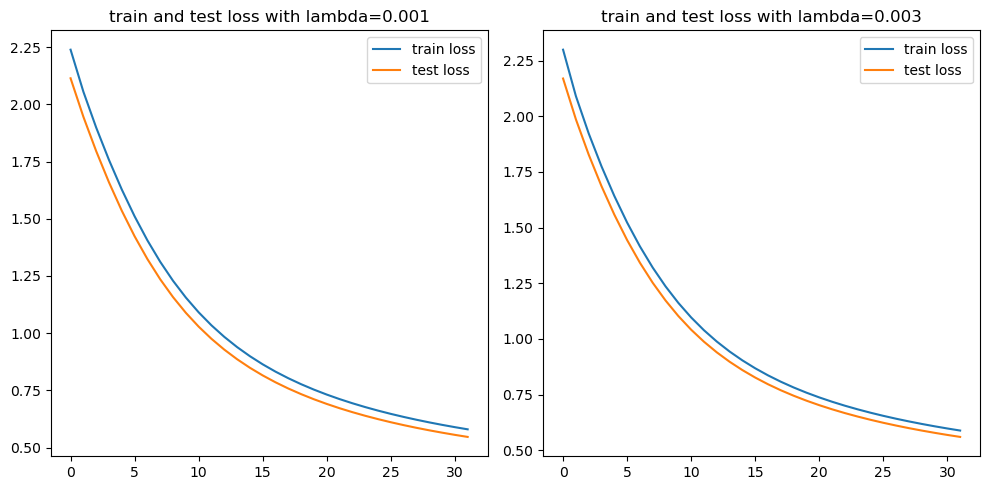

In [52]:
figure, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(train_loss_list_lambda1, label="train loss")
axes[0].plot(test_loss_list_lambda1, label="test loss")
axes[0].set_title(f"train and test loss with lambda={wd1}")
axes[0].legend()
axes[1].plot(train_loss_list_lambda2, label="train loss")
axes[1].plot(test_loss_list_lambda2, label="test loss")
axes[1].set_title(f"train and test loss with lambda={wd2}")
axes[1].legend()
plt.tight_layout()
plt.show()

### 6.2 使用torch.nn实现L2正则化

In [53]:
class Model(nn.Module):
    def __init__(
        self, input_dim: int, hidden_dim: int, output_dim: int, device: torch.device
    ) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            # nn.Softmax(dim=1)
        ).to(device)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data, nonlinearity="relu")
                nn.init.zeros_(m.bias.data)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.model(X)#.squeeze(-1)

In [54]:
class Loss:
    def __init__(self) -> None:
        self.criterion = nn.CrossEntropyLoss()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.criterion(y_pred, y_true)

In [55]:
class Optimizer:
    def __init__(self, model: Model, lr: float, weight_decay: float) -> None:
        bias_params = []
        weight_params = []
        for name, param in model.named_parameters():
            if "bias" in name:
                bias_params.append(param)
            elif "weight" in name:
                weight_params.append(param)
        optimizer_params = [
            {"params": weight_params, "lr": lr, "weight_decay": weight_decay},
            {"params": bias_params, "lr": lr, "weight_decay": 0.0},
        ]
        self.optimizer = torch.optim.SGD(optimizer_params)

    def step(self) -> None:
        self.optimizer.step()

    def zero_grad(self) -> None:
        self.optimizer.zero_grad()

In [56]:
def evaluate_loss(
    model: Model, loss: Loss, data_loader: DataLoader, device: torch.device
) -> float:
    model.eval()
    total_loss = 0.0
    total_num = 0
    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)

            predicts = model(features)
            loss_value = loss.calc(predicts, labels)

            total_num += len(labels)
            total_loss += loss_value.item() * len(labels)
        model.train()
        return total_loss / total_num

In [57]:
def train(
    num_epoches: int,
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_loader: DataLoader,
    test_loader: DataLoader,
    device: torch.device,
):
    train_loss_list, test_loss_list = [], []

    for epoch in range(num_epoches):
        model.train()
        total_num = 0
        train_loss_val = 0
        test_loss_val = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            predicts = model(features)
            loss_value = loss.calc(predicts, labels)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            with torch.no_grad():
                total_num += len(labels)
                train_loss_val += loss_value.item() * len(labels)
        train_loss_list.append(train_loss_val / total_num)
        test_loss_val = evaluate_loss(model, loss, test_loader, device)
        test_loss_list.append(test_loss_val)
        print(
            f"Epoch {epoch + 1}/{num_epoches}, Train Loss: {train_loss_list[-1]:.4f}, Test Loss: {test_loss_list[-1]:.4f}"
        )
    return train_loss_list, test_loss_list

In [58]:
num_epoches = 32
input_dim = 1 * 28 * 28
hidden_dim = 256
output_dim = 10
### ==================================================================
model1 = Model(input_dim, hidden_dim, output_dim, devc)
model2 = Model(input_dim, hidden_dim, output_dim, devc)
# ==================================================================
loss = Loss()
lr = 0.03
### ==================================================================
wd1 = 0.001
wd2 = 0.003
optimizer_wd1 = Optimizer(model1, lr, wd1)
optimizer_wd2 = Optimizer(model2, lr, wd2)
# ==================================================================
batch_size = 10240
train_loader = train_iter(batch_size)
test_loader = test_iter(batch_size)

train_loss_list_wd1, test_loss_list_wd1 = train(
    num_epoches, model1, loss, optimizer_wd1, train_loader, test_loader, devc
)
train_loss_list_wd2, test_loss_list_wd2 = train(
    num_epoches, model2, loss, optimizer_wd2, train_loader, test_loader, devc
)

Epoch 1/32, Train Loss: 2.3330, Test Loss: 2.2005
Epoch 2/32, Train Loss: 2.1195, Test Loss: 2.0065
Epoch 3/32, Train Loss: 1.9406, Test Loss: 1.8359
Epoch 4/32, Train Loss: 1.7821, Test Loss: 1.6836
Epoch 5/32, Train Loss: 1.6406, Test Loss: 1.5483
Epoch 6/32, Train Loss: 1.5150, Test Loss: 1.4287
Epoch 7/32, Train Loss: 1.4039, Test Loss: 1.3235
Epoch 8/32, Train Loss: 1.3064, Test Loss: 1.2316
Epoch 9/32, Train Loss: 1.2209, Test Loss: 1.1512
Epoch 10/32, Train Loss: 1.1461, Test Loss: 1.0810
Epoch 11/32, Train Loss: 1.0807, Test Loss: 1.0197
Epoch 12/32, Train Loss: 1.0233, Test Loss: 0.9660
Epoch 13/32, Train Loss: 0.9729, Test Loss: 0.9187
Epoch 14/32, Train Loss: 0.9285, Test Loss: 0.8770
Epoch 15/32, Train Loss: 0.8890, Test Loss: 0.8399
Epoch 16/32, Train Loss: 0.8539, Test Loss: 0.8069
Epoch 17/32, Train Loss: 0.8225, Test Loss: 0.7773
Epoch 18/32, Train Loss: 0.7943, Test Loss: 0.7509
Epoch 19/32, Train Loss: 0.7688, Test Loss: 0.7268
Epoch 20/32, Train Loss: 0.7458, Test Lo

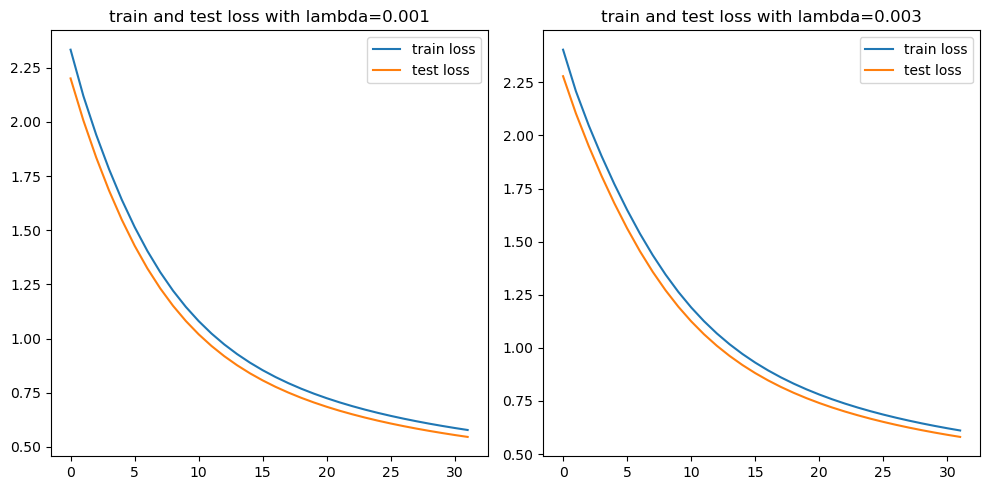

In [59]:
figure, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(train_loss_list_wd1, label="train loss")
axes[0].plot(test_loss_list_wd1, label="test loss")
axes[0].set_title(f"train and test loss with lambda={wd1}")
axes[0].legend()
axes[1].plot(train_loss_list_wd2, label="train loss")
axes[1].plot(test_loss_list_wd2, label="test loss")
axes[1].set_title(f"train and test loss with lambda={wd2}")
axes[1].legend()
plt.tight_layout()
plt.show()

## 7 对回归、二分类、多分类任务分别选择上述实验中效果最好的模型，采用10折交叉验证评估实验结果
要求除了最终结果外还需以表格的形式展示每折的实验结果

In [60]:
# NOTE 题目4：再次重构Model类，增加传入的参数"hidden_layers_num"，使得模型可以有多个隐藏层。
class Model(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        device: torch.device,
        activation_fn: nn.Module = nn.ReLU(),
        hidden_layers_num: int = 1,
    ) -> None:
        super().__init__()
        hidden_layers = []
        for _ in range(hidden_layers_num - 1):  # 注意是 hidden_layers_num-1
            hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            hidden_layers.append(activation_fn)
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),  # 第一层
            activation_fn,  # 激活函数
            *hidden_layers,  # 解包所有隐藏层
            nn.Linear(hidden_dim, output_dim),  # 输出层
        ).to(device)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data, nonlinearity="relu")
                nn.init.zeros_(m.bias.data)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.model(X)  # .squeeze(-1)

In [61]:
class Loss:
    def __init__(self) -> None:
        self.criterion = nn.CrossEntropyLoss()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.criterion(y_pred, y_true)

In [62]:
class Optimizer:
    def __init__(self, model: Model, lr: float = 0.01) -> None:
        self.optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    def step(self) -> None:
        self.optimizer.step()

    def zero_grad(self) -> None:
        self.optimizer.zero_grad()

In [63]:
def evaluate_loss(
    model: Model, loss: Loss, data_loader: DataLoader, device: torch.device
) -> float:
    model.eval()
    total_loss = 0.0
    total_num = 0
    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)

            predicts = model(features)
            loss_value = loss.calc(predicts, labels)

            total_num += len(labels)
            total_loss += loss_value.item() * len(labels)
        model.train()
        return total_loss / total_num

In [64]:
def train(
    num_epoches: int,
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_loader: DataLoader,
    test_loader: DataLoader,
    device: torch.device,
):
    train_loss_list, test_loss_list = [], []

    for epoch in range(num_epoches):
        model.train()
        total_num = 0
        train_loss_val = 0
        test_loss_val = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            predicts = model(features)
            loss_value = loss.calc(predicts, labels)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            with torch.no_grad():
                total_num += len(labels)
                train_loss_val += loss_value.item() * len(labels)
        train_loss_list.append(train_loss_val / total_num)
        test_loss_val = evaluate_loss(model, loss, test_loader, device)
        test_loss_list.append(test_loss_val)
        print(
            f"Epoch {epoch + 1}/{num_epoches}, Train Loss: {train_loss_list[-1]:.4f}, Test Loss: {test_loss_list[-1]:.4f}"
        )
    return train_loss_list, test_loss_list

In [65]:
from sklearn.model_selection import KFold


def k_fold_cross_validation(
    k: int, batch_size: int, num_epochs: int, device: torch.device
) -> list[dict[str, int]]:
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    # 修改：用于存储每一折的详细结果
    fold_results_details = []

    print(f"--------------------------------")
    print(f"Starting {k}-Fold Cross-Validation")
    print(f"--------------------------------")

    dataset_indices = np.arange(len(train_datasets))

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset_indices)):

        print(f"\n[FOLD {fold + 1}/{k}]")

        # 修复 Subset 的 indices 类型：将 numpy.ndarray 转换为 list
        train_sub = Subset(train_datasets, train_ids.tolist())
        val_sub = Subset(train_datasets, val_ids.tolist())

        train_loader = DataLoader(train_sub, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_sub, batch_size=batch_size, shuffle=False)

        # 重新初始化模型
        model = Model(
            input_dim=28 * 28,
            hidden_dim=128,
            output_dim=10,
            device=device,
            hidden_layers_num=2,
        )
        loss_fn = Loss()
        optimizer = Optimizer(model, lr=0.01)

        # 训练
        train_loss_hist, val_loss_hist = train(
            num_epoches=num_epochs,
            model=model,
            loss=loss_fn,
            optimizer=optimizer,
            train_loader=train_loader,
            test_loader=val_loader,
            device=device,
        )

        final_val_loss = val_loss_hist[-1]

        # 记录这一折的详细结果
        fold_results_details.append(
            {
                "Fold": fold + 1,
                "Train Loss": train_loss_hist[-1],  # 最后一轮的训练损失
                "Validation Loss": final_val_loss,  # 最后一轮的验证损失
                "Train Size": len(train_ids),
                "Validation Size": len(val_ids),
            }
        )

        print(f"--> Fold {fold + 1} Finished. Final Val Loss: {final_val_loss:.4f}")
    return fold_results_details

In [66]:
# 配置参数
K = 10
BATCH_SIZE = 256
EPOCHS = 32  # 示例值

# 运行交叉验证，接收包含详细结果的列表
results_details = k_fold_cross_validation(K, BATCH_SIZE, EPOCHS, devc)

# --- 打印表格结果 ---

print(f"\n\n==========================================")
print(f"{K}-Fold 交叉验证 实验结果")
print(f"==========================================")

# 打印表头
print("| Fold | 训练集大小 | 验证集大小 | 最终训练 Loss | 最终验证 Loss |")
print("|------|----------|----------|--------------|--------------|")

# 打印每折结果
validation_losses = []
for row in results_details:
    print(
        f"| {row['Fold']:<4} | "
        f"{row['Train Size']:<10} | "
        f"{row['Validation Size']:<10} | "
        f"{row['Train Loss']:.6f} | "
        f"**{row['Validation Loss']:.6f}** |"  # 强调验证损失
    )
    validation_losses.append(row["Validation Loss"])

# 计算并打印平均结果
avg_loss = np.mean(validation_losses)
std_dev = np.std(validation_losses)

print("\n--- 汇总统计 ---")
print(f"验证集平均 Loss: **{avg_loss:.6f}**")
print(f"验证集 Loss 标准差: {std_dev:.6f} (衡量模型稳定性)")
print(f"==========================================")

--------------------------------
Starting 10-Fold Cross-Validation
--------------------------------

[FOLD 1/10]
Epoch 1/32, Train Loss: 1.5451, Test Loss: 0.9484
Epoch 2/32, Train Loss: 0.7171, Test Loss: 0.5770
Epoch 3/32, Train Loss: 0.5114, Test Loss: 0.4579
Epoch 4/32, Train Loss: 0.4313, Test Loss: 0.4000
Epoch 5/32, Train Loss: 0.3872, Test Loss: 0.3648
Epoch 6/32, Train Loss: 0.3584, Test Loss: 0.3394
Epoch 7/32, Train Loss: 0.3373, Test Loss: 0.3210
Epoch 8/32, Train Loss: 0.3207, Test Loss: 0.3064
Epoch 9/32, Train Loss: 0.3071, Test Loss: 0.2942
Epoch 10/32, Train Loss: 0.2953, Test Loss: 0.2832
Epoch 11/32, Train Loss: 0.2850, Test Loss: 0.2748
Epoch 12/32, Train Loss: 0.2759, Test Loss: 0.2666
Epoch 13/32, Train Loss: 0.2677, Test Loss: 0.2590
Epoch 14/32, Train Loss: 0.2601, Test Loss: 0.2518
Epoch 15/32, Train Loss: 0.2531, Test Loss: 0.2459
Epoch 16/32, Train Loss: 0.2468, Test Loss: 0.2395
Epoch 17/32, Train Loss: 0.2408, Test Loss: 0.2341
Epoch 18/32, Train Loss: 0.23